# Library Imports & Updates

In [5]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 76.4 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc,recall_score,precision_score, accuracy_score, RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize, LabelBinarizer

# Fetching & Splitting Data

In [7]:
def get_data():
  df = pd.read_csv("Sensorless_drive_diagnosis.txt", sep=' ', header=None)
  #txt file is uploaded to colab manually
  df = df.astype({col: 'float' for col in df.columns})

  if len(df)!= 58509: #got this number from the UCI link in the homework file
    print("Data length does not match repository!")
  if len(df.columns)!=49:#got this number from the UCI link in the homework file
    print("No of columns does not match repository!")
  if df.isnull().values.any()==True:
    print("Missing values!")
  
  return df


In [8]:
df=get_data()

In [9]:
def split_data(df):
  x = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  x_remain, x_test, y_remain, y_test = train_test_split(x,y, test_size=0.2, random_state=42) 
      #20% of the original dataset is seperated as test data
      
  x_train, x_valid, y_train, y_valid = train_test_split(x_remain,y_remain,test_size=0.25,random_state=42)
      #80% of the original data remains. 25% of the remaining data, which equals to 20% of the 
      #original data  (because (0.8)*(0.25)=0.2) is seperated as validation data.
      #Remaining data, which is 60% of the original data, is set as training data.
  if not (len(x)*0.6 -1) <= x_train.shape[0] <= (len(x)*0.6 +1): #+1 -1 in case there is odd number of data
    print("Error in splitting!")
  if not (len(x)*0.2 -1) <= x_test.shape[0] <= (len(x)*0.2 +1):
    print("Error in splitting!")
  if not (len(x)*0.2 -1) <= x_valid.shape[0] <= (len(x)*0.2 +1): 
    print("Error in splitting!")
  
  return x_train, x_valid, x_test, y_train, y_valid, y_test

In [10]:
x_train, x_valid, x_test, y_train, y_valid, y_test=split_data(df)

# Validation Tasks

In [ ]:
def valid_n_estimators(x_train, x_valid,y_train, y_valid):
  cv = KFold(n_splits=5, random_state=1, shuffle=True)
  learning_rate = 0.1
  no_of_trees = [10, 50, 100, 500]
  auc_scores = [] #will store values to plot later
  for i in cv.split(x_train):
    for item in no_of_trees:
      model = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=item,multi_class='ovr',tree_method="gpu_hist") 
      #for multi-class classification, have to set multi_class to ovo or ovr.
      #ovr stands for one versus rest, ovo stands for one verses other
      #ran it on the GPU to fasten it up
      model.fit(x_train, y_train)
      auc = roc_auc_score(y_valid, model.predict_proba(x_valid), average="micro",multi_class="ovr")
      auc_scores.append([auc,item])
    df_tuning_trees = pd.DataFrame (auc_scores,columns=['AUC',"No of Trees"])

  kfoldCV = df_tuning_trees.groupby("No of Trees")
  kfoldCV = kfoldCV.mean()
  kfoldCV = kfoldCV.reset_index()
  kfoldCV[['No of Trees', "AUC"]]
  print(kfoldCV)

  kfoldCV.plot(x = 'No of Trees', y = 'AUC', color="m",title="5 Fold CV")

   No of Trees       AUC
0           10  0.992246
1           50  0.999103
2          100  0.999871
3          500  0.999976


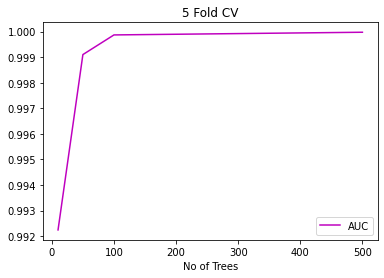

In [ ]:
valid_n_estimators(x_train, x_valid,y_train, y_valid)

In [ ]:
def valid_max_depth(x_train, x_valid,y_train, y_valid):
  cv = KFold(n_splits=5, random_state=1, shuffle=True)
  learning_rate = 0.1
  n_estimators = 500 #from the previous validation 
  max_depth_values = [4,6,8]
  auc_scores = []  #will store values to plot later
  for i in cv.split(x_train):
    for item in max_depth_values:
        model = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=item, multi_class='ovr',tree_method="gpu_hist" )
        #ran this on the GPU to fasten it up
        model.fit(x_train, y_train)
        auc = roc_auc_score(y_valid, model.predict_proba(x_valid), average="micro",multi_class="ovr")
        auc_scores.append([auc,item])
    df_tuning_depth = pd.DataFrame (auc_scores,columns=['AUC',"Max Depth"])

  kfoldCV = df_tuning_depth.groupby("Max Depth")
  kfoldCV = kfoldCV.mean()
  kfoldCV = kfoldCV.reset_index()
  kfoldCV[['Max Depth', "AUC"]]
  print(kfoldCV)

  kfoldCV.plot(x = 'Max Depth', y = 'AUC', color="b",title="5 Fold CV")

   Max Depth       AUC
0          4  0.999993
1          6  0.999998
2          8  0.999998


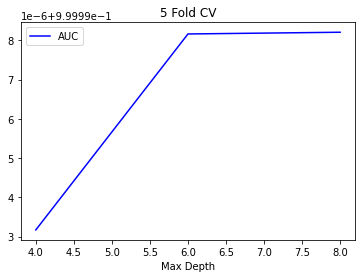

In [ ]:
valid_max_depth(x_train, x_valid,y_train, y_valid)

In [ ]:
#can be chosen both 6 and 8.
#for a simpler model, 6 is chosen

In [ ]:
def valid_lr(x_train, x_valid,y_train, y_valid):
  cv = KFold(n_splits=5, random_state=1, shuffle=True)
  learning_rates = [0.001,0.01,0.1]
  n_estimators = 500 #from the previous validation 
  max_depth = 6 #from the previous validation 
  auc_scores = []  #will store values to plot later
  for i in cv.split(x_train):
    for item in learning_rates:
        model = xgb.XGBClassifier(learning_rate=item, n_estimators=n_estimators, max_depth=max_depth, multi_class='ovr',tree_method="gpu_hist")
        model.fit(x_train, y_train)
        auc = roc_auc_score(y_valid, model.predict_proba(x_valid), average="micro",multi_class="ovr")
        auc_scores.append([auc,item])
    df_tuning_lr = pd.DataFrame (auc_scores,columns=['AUC',"Learning Rate"])
  
  kfoldCV = df_tuning_lr.groupby("Learning Rate")
  kfoldCV = kfoldCV.mean()
  kfoldCV = kfoldCV.reset_index()
  kfoldCV[['Learning Rate', "AUC"]]
  print(kfoldCV)

  kfoldCV.plot(x = 'Learning Rate', y = 'AUC', color="g",title="5 Fold CV")


   Learning Rate       AUC
0          0.001  0.998854
1          0.010  0.999935
2          0.100  0.999998


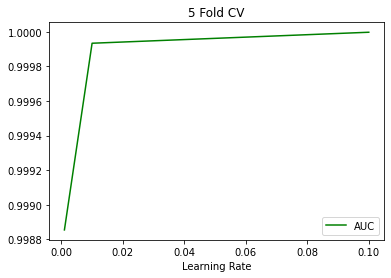

In [ ]:
valid_lr(x_train, x_valid,y_train, y_valid)

# Test Performance

In [24]:
def final_model(x_train, x_valid,x_test,y_train, y_valid,y_test):
  frames = [x_train,x_valid]
  x_train=pd.concat(frames).reset_index(drop=True)
  frames = [y_train,y_valid]
  y_train=pd.concat(frames).reset_index(drop=True) #combined train&validation sets

  model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=6, multi_class='ovr',tree_method="gpu_hist")
  model.fit(x_train, y_train) 
  y_pred_proba=model.predict_proba(x_test)
  y_pred=model.predict(x_test)

  auc = roc_auc_score(y_test,y_pred_proba,multi_class="ovr")
  print("Model AUC Score:", auc)
  accuracy=accuracy_score(y_test,y_pred)
  print("Model Accuracy:",accuracy)
  prec=precision_score(y_test,y_pred,average="micro")
  print("Precision Score:",prec)
  recall=recall_score(y_test,y_pred,average="micro")
  print("Recall:",recall)
  
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)

  RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_pred_proba.ravel(),
    name="Micro Average OvR AUC",
    color="r",
  )
  plt.plot([0, 1], [0, 1], "k--", label="AUC = 0.5")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Micro-averaged OvR\nROC")
  plt.legend()
  plt.show() #for the entire model

  num_classes=11 #got this info from the UCI link in the homework file
  label_binarizer = LabelBinarizer().fit(y_train)
  y_onehot_test = label_binarizer.transform(y_test)
  for i in range(1, num_classes+1):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    print("ROC For Class", class_id, "vs Rest")

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_proba[:, class_id],
        name=f"{i} vs the rest",
        color="b",
    )

    plt.plot([0, 1], [0, 1], "k--", label="AUC = 0.5")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curve")
    plt.legend()
    plt.show() #for each class vs rest

Model AUC Score: 0.9999978016109684
Model Accuracy: 0.9991454452230388
Precision Score: 0.9991454452230388
Recall: 0.9991454452230388


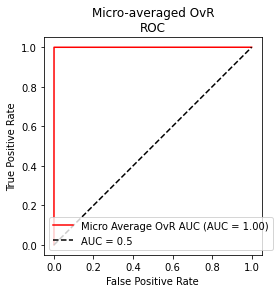

ROC For Class 0 vs Rest


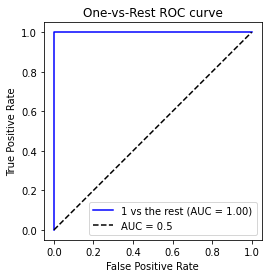

ROC For Class 1 vs Rest


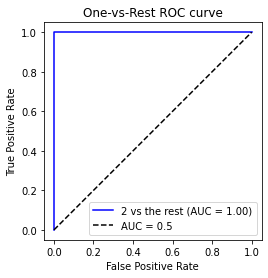

ROC For Class 2 vs Rest


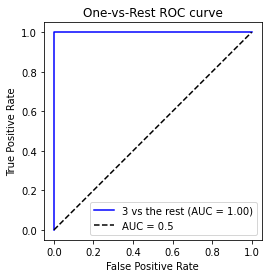

ROC For Class 3 vs Rest


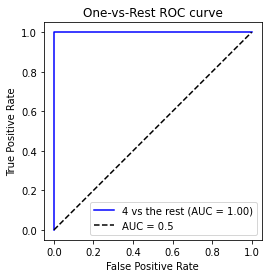

ROC For Class 4 vs Rest


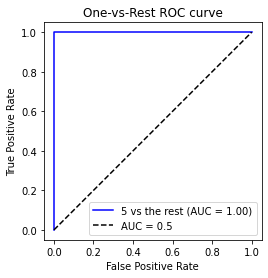

ROC For Class 5 vs Rest


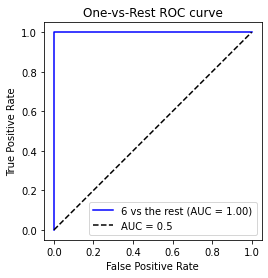

ROC For Class 6 vs Rest


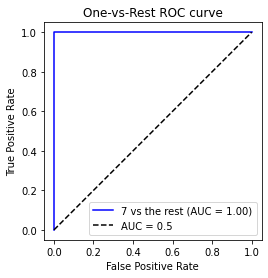

ROC For Class 7 vs Rest


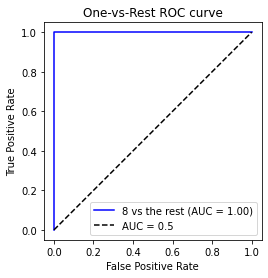

ROC For Class 8 vs Rest


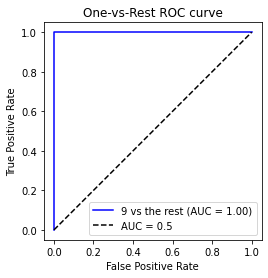

ROC For Class 9 vs Rest


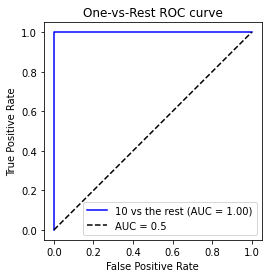

ROC For Class 10 vs Rest


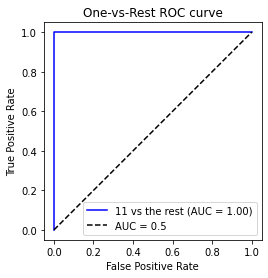

In [25]:
final_model(x_train, x_valid,x_test,y_train, y_valid,y_test)